In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from nbdev import *
%nbdev_default_export data_realsr

Cells will be exported to srthesis.data_realsr,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Config



In [ ]:
%nbdev_export_internal
from fastai.vision import *
from PIL import Image as PILImage
import multiprocessing

In [ ]:
%nbdev_export_internal
path_dataset = Path('datasets/RealSR')

# Generating test patches

In [ ]:
import os
path_canon = path_dataset/"Canon"/"Valid"/"2"
path_nikon = path_dataset/"Nikon"/"Valid"/"2"
fnames = [path_canon/f for f in os.listdir(path_canon) if 'LR2' in f]
fnames += [path_nikon/f for f in os.listdir(path_nikon) if 'LR2' in f]

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

In [ ]:
img_fname = ""

@interact
def image_preview(fname = fnames):
    global img_fname
    img_fname = fname

    img = PILImage.open(fname)
    print(str(fname))
    return img.resize((200,200))

interactive(children=(Dropdown(description='fname', options=(PosixPath('datasets/RealSR/Canon/Valid/2/Canon_01…

In [ ]:
tg_sz = 128
img = PILImage.open(img_fname)
size = list(img.size)
@interact
def image_crop(x = (0, size[0], 10), y = (0, size[1], 10)):

    print(f"(Path({str(img_fname)}), {(x,y)}), \\")
    return img.crop((x,y,x+tg_sz,y+tg_sz))

interactive(children=(IntSlider(value=800, description='x', max=1600, step=10), IntSlider(value=950, descripti…

In [ ]:
%nbdev_export_internal
selected_patches = [ \
            (Path('datasets/RealSR/Canon/Valid/2/Canon_003_LR2.png'), (1200, 1050)), \
            (Path('datasets/RealSR/Canon/Valid/2/Canon_010_LR2.png'), (1320, 790)), \
            (Path('datasets/RealSR/Canon/Valid/2/Canon_015_LR2.png'), (750, 780)), \
            (Path('datasets/RealSR/Canon/Valid/2/Canon_006_LR2.png'), (680, 540)), \
            (Path('datasets/RealSR/Nikon/Valid/2/Nikon_006_LR2.png'), (660, 1160)), \
            (Path('datasets/RealSR/Nikon/Valid/2/Nikon_010_LR2.png'), (1020, 1050)), \
            (Path('datasets/RealSR/Nikon/Valid/2/Nikon_012_LR2.png'), (540, 700)), \
            (Path('datasets/RealSR/Nikon/Valid/2/Nikon_014_LR2.png'), (1200, 700)), \
           ]

In [ ]:
%nbdev_export

test_patches = [path_dataset/ "Test" / Path(fn).name for fn, _ in selected_patches]

In [ ]:
p = path_dataset/"Test"

def _generate_test_set():
    for fname, crop_pos in test_set:

        print(fname)
        fname_lr = fname
        fname_hr = fname.replace('LR2','HR')

        print(fname, fname_lr, fname_hr)
        
        img_hr = PILImage.open(fname_hr)
        img_lr = PILImage.open(fname_lr)
        x,y = crop_pos
        patch_hr = img_hr.crop((x,y,x+tg_sz,y+tg_sz))
        patch_lr = img_lr.crop((x,y,x+tg_sz,y+tg_sz))
        fpath_hr = p / Path(fname).name
        fpath_lr = p / Path(fname_lr).name
        patch_hr.save(fpath_hr)
        patch_lr.save(fpath_lr)

if not p.exists(): 
    p.mkdir(parents=True, exist_ok=True)
    _generate_test_set()

# Dataset

In [ ]:
%nbdev_export


class CachedImageList(ImageImageList):
    _map = {}
    
    def open(self, i):        
        item = self._map.get(str(i))
        if isinstance(item, Image):
            return item
        item = super().open(i)
        self._map[str(i)] = item
        
        return item
    
class CachedImageImageList(CachedImageList):
    _label_cls = CachedImageList    

In [ ]:
%nbdev_export_internal

def _repeat_il(il:ImageList, times:int=2)->ImageList:
    il_orig = il.new(il.items)
    for i in range(times - 1):
        il.add(il_orig)
    return il

def _get_il(input_type:str='LR2'):
    
    il_canon = CachedImageImageList.from_folder(path_dataset / 'Canon') \
               .filter_by_func(lambda fname: '/2/' in str(fname)) \
               .filter_by_func(lambda fname: input_type in str(fname))

    il_nikon = CachedImageImageList.from_folder(path_dataset / 'Nikon') \
                       .filter_by_func(lambda fname: '/2/' in str(fname)) \
                       .filter_by_func(lambda fname: input_type in str(fname))

    il_canon.add(il_nikon)
    il = il_canon
    
    return il

def _get_src(keep_pct: float = 1.0, 
             random_seed: int = 42,
             input_type:str='LR2',
             repeat_train:int = 1,
             max_train_len: int = sys.maxsize):
    
    il = _get_il(input_type=input_type)
   
    if keep_pct < 1.0:
         il = il.use_partial_data(sample_pct=keep_pct, seed=random_seed)
    
    src = il.split_by_folder(train="Train", valid = "Valid")
    
    if max_train_len < sys.maxsize:
        rand_idx = np.random.permutation(range_of(src.train))
        src.train = src.train[rand_idx[:max_train_len]]
    
    if repeat_train > 1:
        src.train = _repeat_il(src.train, repeat_train)
    
    src.path = src.path.parent
    
    return src

def _get_tfms(y_size:int, dihedral_augs:bool=True):
    crop_rand_patches = crop(size=(y_size,y_size),  row_pct=(0,1), col_pct=(0,1))# pct 
    crop_center_patches = crop(size=(y_size,y_size),  row_pct=0.5, col_pct=0.5)# pct 
    #TODO brightness and contrast
    #TODO noise
    train_tfms = [crop_rand_patches]
    if dihedral_augs:
        train_tfms += [dihedral_affine()]
    valid_tfms = [crop_rand_patches]
    return [train_tfms, valid_tfms]
    

In [ ]:
il = _get_il()

In [ ]:
src = _get_src(max_train_len=60, repeat_train=100)
src

ItemLists;

Train: CachedImageImageList (6000 items)
Image (3, 1000, 1200),Image (3, 1000, 1500),Image (3, 1000, 1500),Image (3, 1600, 1900),Image (3, 1500, 1400)
Path: datasets/RealSR/Canon;

Valid: CachedImageImageList (30 items)
Image (3, 1900, 1600),Image (3, 1000, 900),Image (3, 1200, 1500),Image (3, 2100, 1600),Image (3, 2100, 2300)
Path: datasets/RealSR/Canon;

Test: None

In [ ]:
%nbdev_export
"""Obtain DataBunch for given target image size and batch size"""
def get_data_realsr(y_size,
             bs,
             keep_pct: float = 1.0,
             xtra_tfms=[],
             random_seed: int = 43,       
             input_type:str = 'LR2', 
             output_type:str = 'HR',
             repeat_train = 1,
             max_train_len: int = sys.maxsize,
             dihedral_augs = True,
             stats: tuple = imagenet_stats) -> ImageDataBunch:
    
    src = _get_src(keep_pct, random_seed, input_type, repeat_train, max_train_len)

    ll = src.label_from_func(lambda fname: str(fname).replace(input_type,output_type))
    
    iters_in_epoch = int(math.ceil(len(src.train) / float(bs)))
    num_workers = min(iters_in_epoch, multiprocessing.cpu_count() // 4)
    
    print(f"Data: Iters in epoch: {iters_in_epoch}, loading threads: {num_workers}")
    
    data = (ll.transform(
                       _get_tfms(y_size, dihedral_augs), 
                       size=None, 
                       tfm_y=True)
                   .databunch(bs=bs, num_workers=num_workers)
                   .normalize(imagenet_stats, do_y=True)
            )
    data.c = 3
    return data

In [ ]:
data = get_data_realsr(128, 16, input_type = 'HR', output_type='LR2', repeat_train = 1, max_train_len = 71)
data

Data: Iters in epoch: 5, loading threads: 5


ImageDataBunch;

Train: LabelList (71 items)
x: CachedImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CachedImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: datasets/RealSR/Canon;

Valid: LabelList (30 items)
x: CachedImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CachedImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: datasets/RealSR/Canon;

Test: None

Show some example inputs and targets in task

$ {LR}_{128px} -> {HR}_{256px} $

CPU times: user 9.46 s, sys: 3.63 s, total: 13.1 s
Wall time: 6.79 s


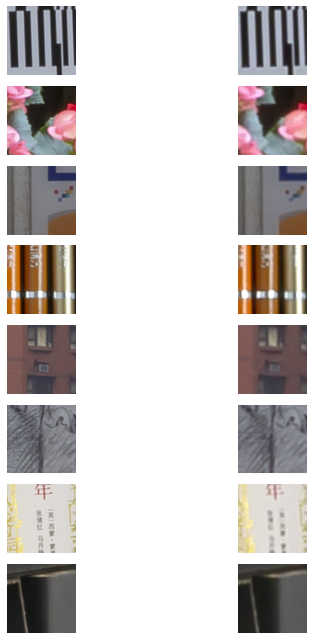

In [ ]:
%%time
data.show_batch(ds_type=DatasetType.Valid, rows=8, figsize=(9,9))

In [ ]:
%nbdev_hide
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 0__template.ipynb.
Converted 10_data.ipynb.
Converted 11_div2k.ipynb.
Converted 12_realsr.ipynb.
Converted 20_metrics.ipynb.
Converted 21_loss.ipynb.
Converted 22_callbacks.ipynb.
Converted 23_tensorboard.ipynb.
Converted 31_generator_learner.ipynb.
Converted 32_critic_learner.ipynb.
Converted 41_generator_pretraining.ipynb.
Converted 42_critic_pretraining.ipynb.
Converted 43_gan_training.ipynb.
Converted augmentations.ipynb.
Converted graphs-tests.ipynb.
Converted sr reference.ipynb.
